In [1]:
import underworld.visualisation as vis
from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as plt
import numpy as np

import os

from scipy.signal import savgol_filter

maxX, maxY, maxZ = np.load("dim.npy")
maxX, maxY, maxZ = float(maxX), float(maxY), float(maxZ)
print (maxX, maxY, maxZ)

resX, resY, resZ = np.load("res.npy")
resX, resY, resZ = int(resX), int(resY), int(resZ)
print (resX, resY, resZ)

minY = minX = minZ = 0.

dx = maxX / resX
dy = maxY / resY
dz = maxZ / resZ

5000.0 1500.0 5000.0
256 128 32


In [3]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY, resZ),
                                minCoord=(minX, minY, minZ),
                                maxCoord=(maxX, maxY, maxZ),
                                periodic=[False, False, False])

surf_ind = np.where(np.logical_and(mesh.data[:,1] == maxY, np.abs(mesh.data[:,2] - (0.25 * maxZ)) < 0.01 * dz))
base_ind = np.where(np.logical_and(mesh.data[:,1] == minY, np.abs(mesh.data[:,2] - (0.25 * maxZ)) < 0.01 * dz))

mesh.load('mesh.h5')

	Global element size: 256x128x32
	Local offset of rank 0: 0x0x0
	Local range of rank 0: 256x128x32


HDF5-DIAG: Error detected in HDF5 (1.12.1) MPI-process 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: 'units'
    major: Attribute
    minor: Object not found


In [4]:
velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)
stressField = mesh.add_variable(nodeDofCount=6)

velocityField.load('velocity.h5')
vdotv  = fn.math.sqrt(fn.math.dot(velocityField,velocityField))

pressureField.load('P.h5')

stressField.load('stress.h5')

# Output

In [5]:
maxY = np.max(mesh.data[surf_ind,1])
minY = np.min(mesh.data[base_ind,1])
print(minY, maxY)

/home/jovyan/workspace/tsa_B.csv
0.0 1500.0


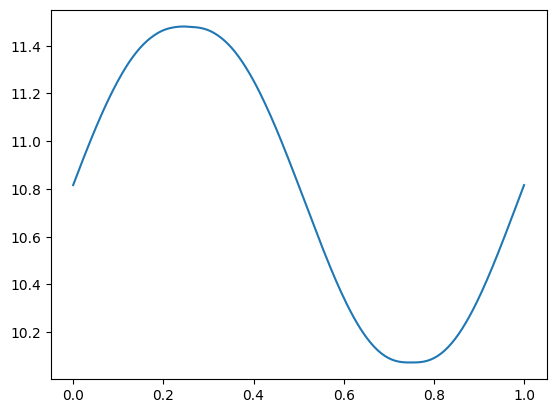

In [9]:
#### Get the surface velocity
vxs = velocityField.data[surf_ind, 0].squeeze()
vys = velocityField.data[surf_ind, 1].squeeze()
vzs = velocityField.data[surf_ind, 2].squeeze()

vtots = np.sqrt( vxs*vxs + vys*vys + vzs*vzs )

plt.plot(mesh.data[surf_ind, 0].squeeze()/maxX, vxs)
plt.show()

P


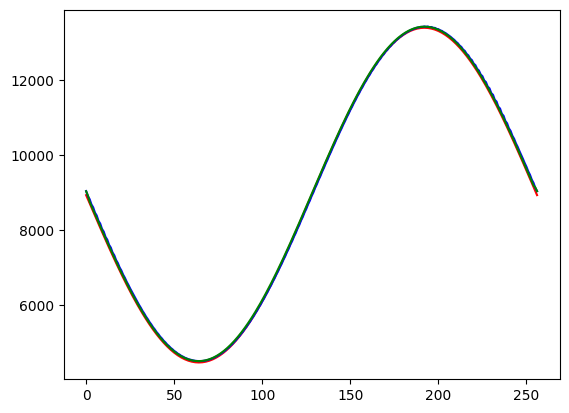

Delta P


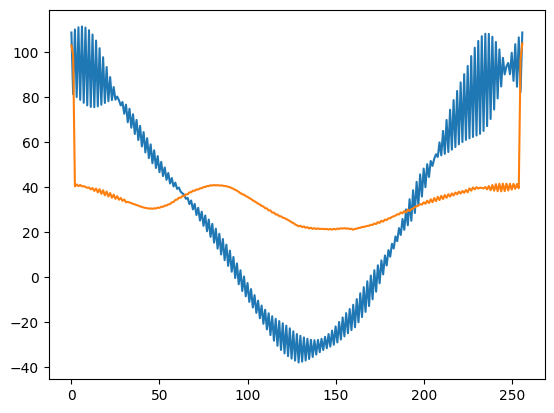

vsx


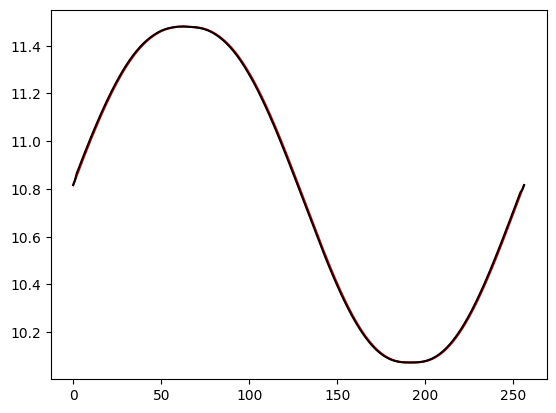

vzs


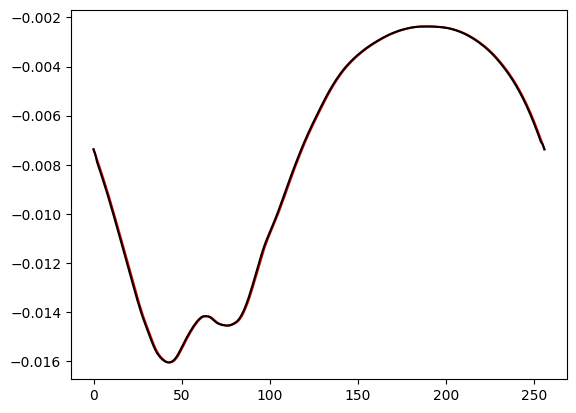

vys


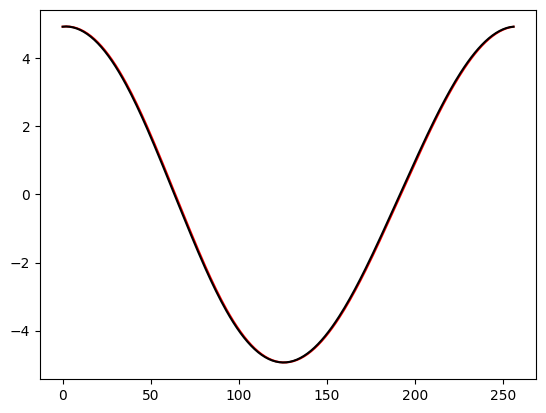

vtots


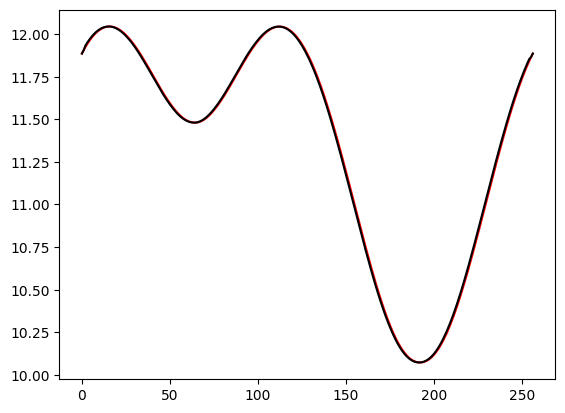

Shear stress


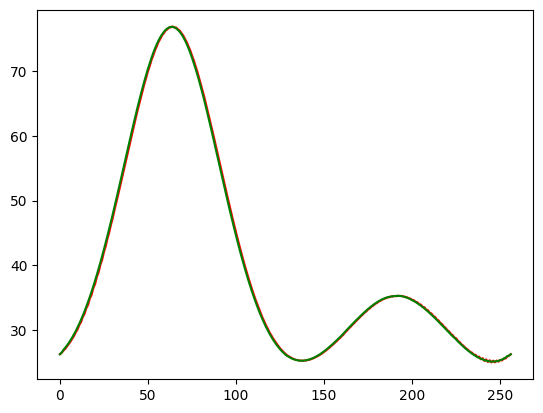

In [7]:
#### Get the pressure
P = pressureField.data[base_ind].squeeze()
#P = pressureField.evaluate(base_pos).squeeze()

#### Get the shearstress
sxz = stressField.data[base_ind].squeeze()[:,3]
sxy = stressField.data[base_ind].squeeze()[:,4]

#### plot pressure from grid / theoretical / difference
print("P")
plt.plot((maxY - mesh.data[base_ind, 1].squeeze()) * 9.81 * 910 / 1000., color='red')
smoothed_2dg = savgol_filter(P / 1000., window_length = 4, polyorder = 2)
plt.plot(P / 1000., color='blue')
plt.plot(smoothed_2dg, color='green')
plt.show()

print ("Delta P")
P_diff = P / 1000. - (maxY - mesh.data[base_ind, 1].squeeze()) * 9.81 * 910 / 1000.
P_diff_smoothed = smoothed_2dg - (maxY - mesh.data[base_ind, 1].squeeze()) * 9.81 * 910 / 1000.
plt.plot(P_diff)
plt.plot(P_diff_smoothed)
plt.show()

#### plot vx at surface
print("vsx")
smoothed_2dg = savgol_filter(vxs, window_length = 4, polyorder = 2)
plt.plot(vxs, color='red')
plt.plot(smoothed_2dg, color='black')
plt.show()

#### plot vz at surface
print("vzs")
smoothed_2dg = savgol_filter(vzs, window_length = 4, polyorder = 2)
plt.plot(vzs, color='red')
plt.plot(smoothed_2dg, color='black')
plt.show()

#### plot vy at surface
print("vys")
smoothed_2dg = savgol_filter(vys, window_length = 4, polyorder = 2)
plt.plot(vys, color='red')
plt.plot(smoothed_2dg, color='black')
plt.show()

#### plot vx at surface
print("vtots")
smoothed_2dg = savgol_filter(vtots, window_length = 4, polyorder = 2)
plt.plot(vtots, color='red')
plt.plot(smoothed_2dg, color='black')
plt.show()

### plot shear stress
print("Shear stress")
smoothed_sxz = savgol_filter(sxz / 1000., window_length = 4, polyorder = 2)
plt.plot(sxz / 1000., color='red')
plt.plot(smoothed_sxz, color='green')
plt.show()

In [11]:
#### Filename
outputFile = os.path.join(os.path.abspath("."), "tsa_B.csv")
print(outputFile)

#### output to file
with open(outputFile, "w") as text_file:
    
    for i in range(len(surf_ind[0])):
        # Ausgabe [x] [y]

        textline = str("{:.7f}".format(mesh.data[surf_ind[0][i], 0]/maxX)) + "\t" \
        
        #Ausgabe Geschwindigkeiten Surface[vx] [vy] [vz]
        textline += str("{:.7f}".format(vxs[i])) + "\t"# + str("{:.7f}".format(vzs[i])) \
        textline += str("{:.7f}".format(vys[i])) + "\t"
                
        # Scherspannung Basis Tensoren [Txz] [Tyz]
        textline += str("{:.7f}".format(smoothed_sxz[i])) + "\t"# + str("{:.7f}".format(sxy[i] / 1000.)) + "\t"
        
        # Ausgabe delta p
        textline += str("{:.7f}".format((P[i] - float((maxY - mesh.data[surf_ind[0][i], 1].squeeze()))) 
                                          * 9.81 * 910)) + "\n"
        
        text_file.write(textline)
        #print(textline)
# -

/home/jovyan/workspace/tsa_B.csv
